In [1]:
from graphvelo.utils import adj_to_knn
from graphvelo.metrics import cross_boundary_correctness

import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
methods=['celldancer', 'deepvelo', 'unitvelo', 'velovi', 'scv', 'gv']
datasets = ['fucci', 'scv_endocrinogenesis_day15','hematopoiesis_raw', 'dentategyrus_scv', 'organoid']
edges = {'fucci':[['G1-S', 'S'], ['S', 'G2-M'], ['G2-M', 'M'], ['M', 'M-G1'], ['M-G1', 'G1-S']],
         'scv_endocrinogenesis_day15': [['Ngn3 low EP', 'Ngn3 high EP'], ['Ngn3 high EP', 'Pre-endocrine'], ['Pre-endocrine', 'Alpha'], ['Pre-endocrine', 'Beta'], ['Pre-endocrine', 'Delta'], ['Pre-endocrine', 'Epsilon']],
         'hematopoiesis_raw': [['HSC','GMP-like'],['HSC','MEP-like'], ['MEP-like', 'Bas'], ['MEP-like', 'Ery'], ['MEP-like', 'Meg'], ['GMP-like', 'Neu'], ['GMP-like', 'Mon']],
         'dentategyrus_scv': [['nIPC', 'Neuroblast'], ['Neuroblast', 'Granule immature'], ['Granule immature', 'Granule mature']],
         'organoid': [['Stem cells', 'TA cells'], ['Stem cells', 'Enteroendocrine progenitor'], ['Stem cells', 'Goblet cells'], ['TA cells', 'Enterocytes']],
         }
cluster_keys = {'fucci': 'cell_cycle_phase', 'scv_endocrinogenesis_day15': 'clusters', 'hematopoiesis_raw': 'cell_type', 'hgForebrainGlut': 'Clusters', 'dentategyrus_scv': 'clusters', 'organoid': 'cell_type'}
colors = ['#FD7755', '#F7B468', '#9493B3', '#6384AB', '#9DABBF', '#BCDAD5']

fucci


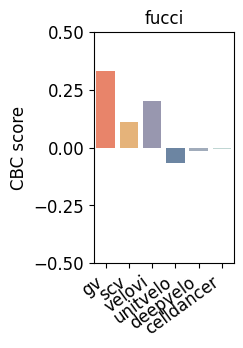

scv_endocrinogenesis_day15


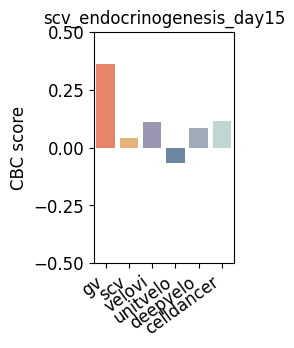

hematopoiesis_raw


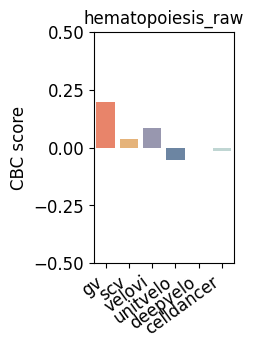

dentategyrus_scv


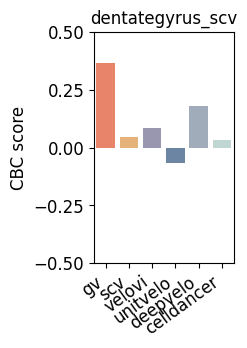

organoid


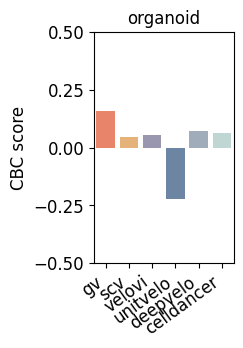

In [3]:
for dataset in datasets:
    print(dataset)
    data_files = [dataset + '_' + method + '.h5ad' for method in methods]
    adata_list = [sc.read('results/' + data_file) for data_file in data_files]

    for ad in adata_list:
        ad.uns['neighbors']['indices'] = adj_to_knn(ad.obsp['connectivities'])[0]

    score_list = []
    for ad in adata_list:
        _, score = cross_boundary_correctness(ad, cluster_key=cluster_keys[dataset], cluster_edges=edges[dataset], xkey='Ms', vkey='velocity', basis='raw')
        score_list.append(score)
    cbc_df = pd.DataFrame(
        np.vstack((
            score_list
        )).T, columns=methods
    )

    cbc_df_mlt = cbc_df.melt()
    cbc_df_mlt.columns = ['type', 'CBC score']

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.8, 3))
    order = list(reversed(methods))
    sns.barplot(x="type", y="CBC score", data=cbc_df_mlt, palette=colors, order=order, ax=ax)

    ax.set_xticklabels(order)
    ax.set_xlabel('')
    ax.lines[0].set_linewidth(0.5)  # whiskers
    ax.lines[1].set_linewidth(0.5)  # caps
    ax.lines[2].set_linewidth(0.5)  # median line
    ax.lines[3].set_linewidth(0.5)  # bottom box line
    ax.lines[4].set_linewidth(0.5)  # top box line
    plt.xticks(rotation = 36, ha='right', fontsize=12) # Rotates X-Axis Ticks by 45-degrees
    plt.yticks([-0.5, -0.25, 0, 0.25, 0.5], fontsize=12)
    plt.ylabel('CBC score', fontsize=12)
    plt.title(dataset)

    # fig.savefig(dpi=300, transparent=True, fname=f'figures/{dataset}_cbc_mean.pdf', bbox_inches = "tight")
    plt.show()
    plt.close(fig)